# Importing packages and setting the requirement for the model

In [45]:
#Importing packages 
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from math import ceil

get_ipython().run_line_magic('matplotlib', 'inline')

#Setting Plot styling 
plt.style.use('seaborn-whitegrid')

#Calculating the effect size based on expected rates
#Pessimistic speech about climate change convince people to believe in climate change with a mean of 0.13
#New approach, Optimistic speech about climate change will convince people with 2% lift, with a mean of 0.15
#https://machinelearningmastery.com/effect-size-measures-in-python/

effect_size=sms.proportion_effectsize(0.13,0.15)


In [46]:
# Sample size is estimated through Power Analysis
#80% power means that we have about 80% chance to detect that the difference is as statistically significant as in our test with the sample size calculated 
required_n=sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )

#rounding up the sample size
required_n=ceil(required_n)
print("To conduct the hypothesis, we need at least", required_n, "samples from each group")


To conduct the hypothesis, we need at least 4720 samples from each group


# Pulling the data and reformatting it


In [47]:
#This is a A/B testing dataset i found in kaggle.I will transform it to a content that will seem more like a climate change research
df=pd.read_csv(r"C:\Users\aturk\Downloads\ab_data.csv")
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [48]:
#Renaming columns
df.rename(columns={'landing_page':'Speech Type', 'converted':'Convinced'}, inplace=True)
df.head()


,user_id,timestamp,group,Speech Type,Convinced
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [49]:
#Renaming values in columns
df['group'].replace({'control':'Control','treatment':'New'}, inplace=True)
df.head()


,user_id,timestamp,group,Speech Type,Convinced
0,851104,2017-01-21 22:11:48.556739,Control,old_page,0
1,804228,2017-01-12 08:01:45.159739,Control,old_page,0
2,661590,2017-01-11 16:55:06.154213,New,new_page,0
3,853541,2017-01-08 18:28:03.143765,New,new_page,0
4,864975,2017-01-21 01:52:26.210827,Control,old_page,1


In [50]:
#Renaming values in columns
df['Speech Type'].replace({'old_page':'Pessimistic','new_page':'Optimistic'}, inplace=True)
df.head()


,user_id,timestamp,group,Speech Type,Convinced
0,851104,2017-01-21 22:11:48.556739,Control,Pessimistic,0
1,804228,2017-01-12 08:01:45.159739,Control,Pessimistic,0
2,661590,2017-01-11 16:55:06.154213,New,Optimistic,0
3,853541,2017-01-08 18:28:03.143765,New,Optimistic,0
4,864975,2017-01-21 01:52:26.210827,Control,Pessimistic,1


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      294478 non-null  int64 
 1   timestamp    294478 non-null  object
 2   group        294478 non-null  object
 3   Speech Type  294478 non-null  object
 4   Convinced    294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [52]:
pd.crosstab(df['group'],df['Speech Type'])


Speech Type,Optimistic,Pessimistic
group,,
Control,1928,145274
New,145311,1965


In [53]:
#Checking for double users
session_count=df['user_id'].value_counts(ascending=False)
multi_users=session_count[session_count>1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [54]:
#Removing double users
drop_multiple=session_count[session_count>1].index
df=df[~df['user_id'].isin(drop_multiple)]
print(f'The new dataset has {df.shape[0]} entries')

The new dataset has 286690 entries


In [55]:
#Creating sample groups from df dataset
control_sample=df[df['group']=='Control'].sample(n=required_n, random_state=22)
new_sample=df[df['group']=='New'].sample(n=required_n, random_state=22)
ab_test=pd.concat([control_sample, new_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,Speech Type,Convinced
0,763854,2017-01-21 03:43:17.188315,Control,Pessimistic,0
1,690555,2017-01-18 06:38:13.079449,Control,Pessimistic,0
2,861520,2017-01-06 21:13:40.044766,Control,Pessimistic,0
3,630778,2017-01-05 16:42:36.995204,Control,Pessimistic,0
4,656634,2017-01-04 15:31:21.676130,Control,Pessimistic,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,New,Optimistic,0
9436,873211,2017-01-05 00:57:16.167151,New,Optimistic,0
9437,631276,2017-01-20 18:56:58.167809,New,Optimistic,0
9438,662301,2017-01-03 08:10:57.768806,New,Optimistic,0


In [56]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      9440 non-null   int64 
 1   timestamp    9440 non-null   object
 2   group        9440 non-null   object
 3   Speech Type  9440 non-null   object
 4   Convinced    9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [57]:
ab_test['group'].value_counts()
#We need 4720 sample size in each group 

Control    4720
New        4720
Name: group, dtype: int64

# Visualising basic statistics of the groups

In [58]:
success_rate=ab_test.groupby('group')['Convinced']

#Standard deviation of the groups
std_info=lambda x: np.std(x, ddof=0)

#Standard error of the groups
se_info=lambda x: stats.sem(x, ddof=0)

success_rate = success_rate.agg([np.mean, std_info, se_info])
success_rate.columns=['Conversion Rate', 'Standard Deviation', 'Standard Error']

#Expected mean difference was given in 2 digits therefore i set the results to 2 digit
success_rate.style.format("{:.2f}")

#Mean of the control group, 0.12, is lower than expected, 0.13
#Difference of means, 0.01, is lower than expected, 0.02, however it still indicates an improvement

,Conversion Rate,Standard Deviation,Standard Error
group,,,
Control,0.12,0.33,0.00
New,0.13,0.33,0.00


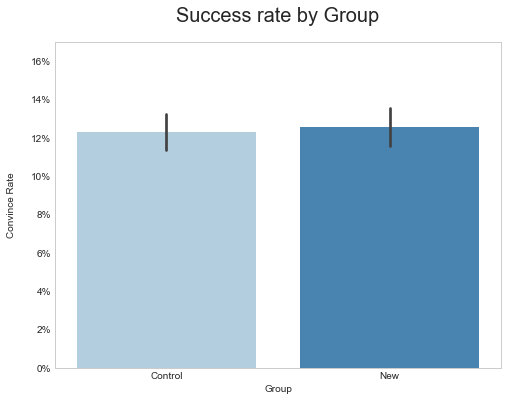

In [60]:
#Visualing the success rate with 95% confidence interval
plt.figure(figsize=(8,6))

x=sns.barplot(x=ab_test['group'] ,y=ab_test['Convinced'], palette='Blues')
x.grid(False)

plt.ylim(0,0.17)
plt.title('Success rate by Group', pad=20, fontsize=20)
plt.ylabel('Convince Rate', labelpad=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.xlabel('Group');

#It is seen that New group who experienced an optimistic speech about climate change had a better success rate
#However we cannot yet say that it is statistically significant without checking the p value as our result migth be positive randomly

# Testing the Hypothesis

In [16]:
#Our sample size is larger than 30, so we can assume that data is distributed normally
#Since we are trying to test a non discrete metric (success rate), sample size is large, \n
#and variances are knows, we can apply Z-test

from statsmodels.stats.proportion import proportions_ztest, proportion_confint


Control_results=ab_test[ab_test['group']=='Control']['Convinced']
NewGroup_results=ab_test[ab_test['group']=='New']['Convinced']

print(Control_results)
print(NewGroup_results)


0       0
1       0
2       0
3       0
4       0
       ..
4715    0
4716    0
4717    0
4718    0
4719    0
Name: Convinced, Length: 4720, dtype: int64
4720    0
4721    0
4722    0
4723    0
4724    0
       ..
9435    0
9436    0
9437    0
9438    0
9439    1
Name: Convinced, Length: 4720, dtype: int64


In [17]:
#Sample size of each group
n_cont=Control_results.count()
n_New=NewGroup_results.count()
print(n_cont)
print(n_New)

4720
4720


In [18]:
#How many people were convinced in each group
print(Control_results.sum())
print(NewGroup_results.sum())

582
593


In [19]:
#Z value, P value and Confidence Interval of Groups' mean distribution
successes=[Control_results.sum(), NewGroup_results.sum()]
nobs=[n_cont, n_New]

z_stat, p_val=proportions_ztest(successes, nobs=nobs)
(lower_cont, lower_new),(upper_cont, upper_new)=proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z statistics: {z_stat:.2f}')
print(f'P-Value: {p_val:.2f}')
print(f'Within 95% confidence, confidence interval of the control group is [{lower_cont:.2f},{upper_cont:.2f}]')
print(f'Within 95% confidence, confidence interval of the new group is [{lower_new:.2f},{upper_new:.2f}]')

Z statistics: -0.34
P-Value: 0.73
Within 95% confidence, confidence interval of the control group is [0.11,0.13]
Within 95% confidence, confidence interval of the new group is [0.12,0.14]


# Reading the results and drawing the conclusion

In [20]:
#Given that we did not know if control group or new group will perform better, null hypothesis is
#H_o: Success rate_0 =Success rate_a
#Success rate of group who had a optimistic speech about climate change is same as the group who had a pessimistic speech

#p value measure the probability of the observed results are by random
#Confidence level = 0.95 and a=1-0.95=0.05 

#p value !< alpha
#0.73!<0.05

#We failed to reject null hypothesis since p value is not higher than the alpha that means 
#optimistic speech about climate change didn't perform statistically different than optimistic speech

#Another supportive statistical information is that expected success rate, 0.15, is higher than the confidence interval of new group
#That means it is unlikely that we can convince more people with optimistic speeches. Sorry world!